In [1]:
# Cell 1: Imports and Setup
import xarray as xr
import numpy as np
import pandas as pd
import glob
import os
import warnings

# Scikit-learn tools
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score

# Plotting
import matplotlib.pyplot as plt

# Ignore harmless warnings
warnings.filterwarnings('ignore')

# This path is confirmed from our previous conversation
data_dir = r"C:\Users\VICTUS\Downloads"

In [2]:
# Cell 2: Load and Clean Data
# Load surface data and fix potential duplicate time steps
surface_files = glob.glob(os.path.join(data_dir, 'surface*.nc'))
ds_surface = xr.open_mfdataset(surface_files, compat='override', join='override')
_, index = np.unique(ds_surface['valid_time'], return_index=True)
ds_surface_clean = ds_surface.isel(valid_time=index)

# Load wind data and remove the single-level pressure dimension
wind_files = glob.glob(os.path.join(data_dir, 'wind*.nc'))
ds_wind = xr.open_mfdataset(wind_files, compat='override', join='override')
ds_wind_clean = ds_wind.squeeze('pressure_level', drop=True)

# Rename time coordinate and merge
ds_surface_clean = ds_surface_clean.rename({'valid_time': 'time'})
ds_wind_clean = ds_wind_clean.rename({'valid_time': 'time'})
ds = xr.merge([ds_surface_clean, ds_wind_clean])

print("--- Final Merged and Cleaned Dataset ---")
print(ds)

--- Final Merged and Cleaned Dataset ---
<xarray.Dataset> Size: 8MB
Dimensions:    (time: 1440, latitude: 17, longitude: 17)
Coordinates:
  * time       (time) datetime64[ns] 12kB 1961-01-01 ... 2020-12-01T06:00:00
  * latitude   (latitude) float64 136B 19.4 19.15 18.9 18.65 ... 15.9 15.65 15.4
  * longitude  (longitude) float64 136B 76.5 76.75 77.0 ... 80.0 80.25 80.5
    number     int64 8B 0
    expver     (time) object 12kB dask.array<chunksize=(720,), meta=np.ndarray>
Data variables:
    tp         (time, latitude, longitude) float32 2MB dask.array<chunksize=(720, 17, 17), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 2MB dask.array<chunksize=(720, 17, 17), meta=np.ndarray>
    msl        (time, latitude, longitude) float32 2MB dask.array<chunksize=(720, 17, 17), meta=np.ndarray>
    u          (time, latitude, longitude) float32 2MB dask.array<chunksize=(720, 17, 17), meta=np.ndarray>
    v          (time, latitude, longitude) float32 2MB dask.array<chunksiz

In [3]:
# Cell 3: Prepare and Split Data
hyd_lat, hyd_lon = 17.4, 78.5

# Target (y): Rainfall at Hyderabad, converted to mm
y = ds['tp'].sel(latitude=hyd_lat, longitude=hyd_lon, method='nearest') * 1000
y.attrs['units'] = 'mm'

# Predictors (X): All other variables from the entire grid, flattened
predictor_vars = ['t2m', 'msl', 'u', 'v']
X = ds[predictor_vars].to_array(dim='variable').stack(features=('variable', 'latitude', 'longitude')).transpose('time', 'features')

# Split data into training and testing sets
X_train_raw = X.sel(time=slice(None, '2009-12-31'))
y_train_raw = y.sel(time=slice(None, '2009-12-31'))

X_test_raw = X.sel(time=slice('2010-01-01', None))
y_test_raw = y.sel(time=slice('2010-01-01', None))

print(f"Total features: {X.shape[1]}")
print(f"Training set size: {X_train_raw.sizes['time']} months")
print(f"Testing set size: {X_test_raw.sizes['time']} months")

Total features: 1156
Training set size: 1176 months
Testing set size: 264 months


In [4]:
# Cell 4: Impute and Scale Data

# --- Clean the Training Data ---
# Handle missing values in y_train by removing them
good_indices_train = ~np.isnan(y_train_raw).compute()
y_train = y_train_raw[good_indices_train]
X_train_unscaled = X_train_raw[good_indices_train]

# --- Clean the Testing Data ---
# Also handle missing values in y_test
good_indices_test = ~np.isnan(y_test_raw).compute()
y_test = y_test_raw[good_indices_test]
X_test_unscaled = X_test_raw[good_indices_test]


# --- Impute and Scale Predictors (X) ---
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Fit scaler and imputer ONLY on training data, then transform both sets
X_train_imputed = imputer.fit_transform(X_train_unscaled)
X_train = scaler.fit_transform(X_train_imputed)

X_test_imputed = imputer.transform(X_test_unscaled)
X_test = scaler.transform(X_test_imputed)

print("Data successfully imputed and scaled for both training and testing sets.")
print("Shape of final X_train:", X_train.shape, " | Shape of final y_train:", y_train.shape)
print("Shape of final X_test:", X_test.shape, "  | Shape of final y_test:", y_test.shape)

Data successfully imputed and scaled for both training and testing sets.
Shape of final X_train: (588, 578)  | Shape of final y_train: (588,)
Shape of final X_test: (132, 578)   | Shape of final y_test: (132,)


In [5]:
# Cell 5: OLS Model
# Initialize a dictionary to store results
results = {}

# Train the OLS model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Make predictions
y_pred_train_ols = ols_model.predict(X_train)
y_pred_test_ols = ols_model.predict(X_test)

# Calculate and store metrics
results['OLS'] = {
    'Train R²': r2_score(y_train, y_pred_train_ols),
    'Test R²': r2_score(y_test, y_pred_test_ols),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_ols)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_ols)),
}

print("OLS model trained and evaluated successfully.")
print(results['OLS'])

OLS model trained and evaluated successfully.
{'Train R²': 0.9013140201568604, 'Test R²': 0.7522897720336914, 'Train RMSE': np.float64(0.7610124492353824), 'Test RMSE': np.float64(1.447135476709648)}


In [6]:
# Cell 6: Stepwise Regression Model
print("Starting Stepwise Regression (Forward Selection)... this may take a while.")

# We'll select the best 15 features to keep the runtime manageable
sfs = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select=15,
    direction='forward',
    cv=3,  # 3-fold cross-validation
    n_jobs=-1 # Use all available CPU cores
)
sfs.fit(X_train, y_train)

# Get the selected features
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)

print(f"\nStepwise selection complete. Selected {X_train_sfs.shape[1]} features.")

# Train a new OLS model on just the selected features
stepwise_model = LinearRegression()
stepwise_model.fit(X_train_sfs, y_train)

# Make predictions and evaluate
y_pred_train_step = stepwise_model.predict(X_train_sfs)
y_pred_test_step = stepwise_model.predict(X_test_sfs)

results['Stepwise'] = {
    'Train R²': r2_score(y_train, y_pred_train_step),
    'Test R²': r2_score(y_test, y_pred_test_step),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_step)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_step)),
}
print("Stepwise model trained and evaluated.")

Starting Stepwise Regression (Forward Selection)... this may take a while.

Stepwise selection complete. Selected 15 features.
Stepwise model trained and evaluated.


In [7]:
# Cell 7: Ridge Regression Model
# Define a range of alpha values to test
alphas = np.logspace(-3, 3, 100)

# RidgeCV will find the best alpha from the list using cross-validation
ridge_model = RidgeCV(alphas=alphas)
ridge_model.fit(X_train, y_train)

print(f"Ridge model trained. Best alpha found: {ridge_model.alpha_:.4f}")

# Make predictions and evaluate
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_test_ridge = ridge_model.predict(X_test)

results['Ridge'] = {
    'Train R²': r2_score(y_train, y_pred_train_ridge),
    'Test R²': r2_score(y_test, y_pred_test_ridge),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_ridge)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_ridge)),
}
print("Ridge model evaluated.")

Ridge model trained. Best alpha found: 0.0376
Ridge model evaluated.


In [8]:
# Cell 8: LASSO Model
# LassoCV will automatically find the best alpha
lasso_model = LassoCV(cv=5, random_state=0, max_iter=10000, n_jobs=-1)
lasso_model.fit(X_train, y_train)

print(f"LASSO model trained. Best alpha found: {lasso_model.alpha_:.4f}")

# Check how many features were eliminated
n_features_lasso = np.sum(lasso_model.coef_ != 0)
print(f"LASSO selected {n_features_lasso} features out of {X_train.shape[1]}.")

# Make predictions and evaluate
y_pred_train_lasso = lasso_model.predict(X_train)
y_pred_test_lasso = lasso_model.predict(X_test)

results['LASSO'] = {
    'Train R²': r2_score(y_train, y_pred_train_lasso),
    'Test R²': r2_score(y_test, y_pred_test_lasso),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_lasso)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_lasso)),
}
print("LASSO model evaluated.")

LASSO model trained. Best alpha found: 0.0015
LASSO selected 86 features out of 578.
LASSO model evaluated.


--- Model Performance Comparison ---
          Train R²  Test R²  Train RMSE  Test RMSE
OLS         0.9013   0.7523      0.7610     1.4471
Stepwise    0.7769   0.7527      1.1443     1.4459
Ridge       0.8679   0.8006      0.8806     1.2984
LASSO       0.7967   0.7139      1.0923     1.5554


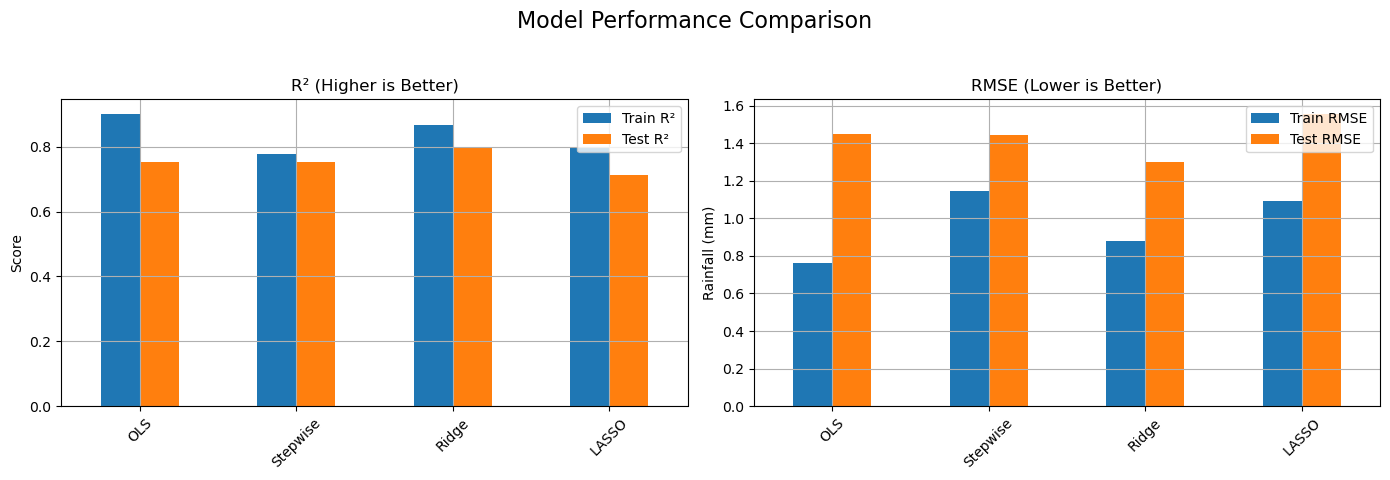

In [9]:
# Cell 9: Compare Results
# Convert the results dictionary to a pandas DataFrame for nice printing
results_df = pd.DataFrame(results).T # .T transposes the DataFrame
results_df = results_df.round(4) # Round to 4 decimal places

print("--- Model Performance Comparison ---")
print(results_df)

# Plotting the results for easier comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
results_df[['Train R²', 'Test R²']].plot(kind='bar', ax=ax[0], grid=True)
ax[0].set_title('R² (Higher is Better)')
ax[0].set_ylabel('Score')
ax[0].tick_params(axis='x', rotation=45)

results_df[['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=ax[1], grid=True)
ax[1].set_title('RMSE (Lower is Better)')
ax[1].set_ylabel('Rainfall (mm)')
ax[1].tick_params(axis='x', rotation=45)

plt.suptitle('Model Performance Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()